In [11]:
from peft import get_peft_model, LoraConfig, TaskType

In [46]:

# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM, 
#     inference_mode=False, 
#     r=8, 
#     lora_alpha=32, 
#     lora_dropout=0.1,
#     target_modules=['query_key_value']
# )
# # 获取基础模型
# model = AutoModel.from_pretrained(
#     "THUDM/chatglm-6b", trust_remote_code=True, device_map="auto"
# )
# # 加入peft config
# model = get_peft_model(model, peft_config)
# # 打印参数情况
# model.print_trainable_parameters()

In [12]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from tqdm import tqdm
from torchvision.utils import save_image
from PIL import Image
from tensorfn import load_config as DiffConfig
import numpy as np
from config.diffconfig import DiffusionConfig, get_model_conf
import torch.distributed as dist
import os, glob, cv2, time, shutil
from models.unet_autoenc import BeatGANsAutoencConfig
from diffusion import create_gaussian_diffusion, make_beta_schedule, ddim_steps
import torchvision.transforms as transforms
import torchvision

## 加载模型

In [36]:
conf = DiffConfig(DiffusionConfig, './config/diffusion.conf', show=False)

model = get_model_conf().make_model()
ckpt = torch.load("checkpoints/last.pt")
model.load_state_dict(ckpt["ema"])
model = model.cuda()
model.eval()

# betas = conf.diffusion.beta_schedule.make()
# diffusion = create_gaussian_diffusion(betas, predict_xstart = False)#.to(device)

# pose_list = glob.glob('data/deepfashion_256x256/target_pose/*.npy')
# transforms = transforms.Compose([transforms.Resize((256,256), interpolation=Image.BICUBIC),
#                     transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),
#                                         (0.5, 0.5, 0.5))])

BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(23, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=128, bia

### 输出模型的结构

In [ ]:
for name, layer in model.named_children():
    print(name, type(layer), sep=" ")

time_embed <class 'models.unet_autoenc.TimeStyleSeperateEmbed'>
input_blocks <class 'torch.nn.modules.container.ModuleList'>
middle_block <class 'models.blocks.TimestepEmbedSequential'>
output_blocks <class 'torch.nn.modules.container.ModuleList'>
out <class 'torch.nn.modules.container.Sequential'>
encoder <class 'models.unet.BeatGANsEncoder'>


In [ ]:
def flatten(module):
    for name, child in module.named_children():
        if isinstance(child, torch.nn.Sequential):
            for sub_name, sub_child in flatten(child):
                yield (f'{name}_{sub_name}', sub_child)
        else:
            yield (name, child)

for (name, layer) in flatten(model):
    print(name, layer, sep=" ")

time_embed TimeStyleSeperateEmbed(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (style): Identity()
)
input_blocks ModuleList(
  (0): TimestepEmbedSequential(
    (0): Conv2d(23, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (1-2): 2 x TimestepEmbedSequential(
    (0): ResBlock(
      (in_layers): Sequential(
        (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (h_upd): Identity()
      (x_upd): Identity()
      (emb_layers): Sequential(
        (0): SiLU()
        (1): Linear(in_features=512, out_features=256, bias=True)
      )
      (cond_emb_layers): Sequential(
        (0): SiLU()
        (1): Linear(in_features=128, out_features=128, bias=True)
      )
      (out_layers): Sequential(
        (0): GroupNorm32(32, 128, ep

In [7]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_feature_size',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_per

In [43]:
import copy
names=[]
for name,param in  model.named_parameters():
    # if(name=='output_blocks.1.0.cond_emb_layers.1.weight'):
    #     print(param)
    #     print(param.shape)
    try:
        model2=copy.copy(model)
        peft_config=LoraConfig(target_modules=[name.replace('.bias', '').replace('.weight', '')])
        model2=get_peft_model(model2, peft_config)
        names.append(name)
    except:
        continue

In [44]:
print(names)

['time_embed.time_embed.0.weight', 'time_embed.time_embed.0.bias', 'time_embed.time_embed.2.weight', 'time_embed.time_embed.2.bias', 'input_blocks.0.0.weight', 'input_blocks.0.0.bias', 'input_blocks.1.0.in_layers.2.weight', 'input_blocks.1.0.in_layers.2.bias', 'input_blocks.1.0.emb_layers.1.weight', 'input_blocks.1.0.emb_layers.1.bias', 'input_blocks.1.0.cond_emb_layers.1.weight', 'input_blocks.1.0.cond_emb_layers.1.bias', 'input_blocks.1.0.out_layers.3.weight', 'input_blocks.1.0.out_layers.3.bias', 'input_blocks.2.0.in_layers.2.weight', 'input_blocks.2.0.in_layers.2.bias', 'input_blocks.2.0.emb_layers.1.weight', 'input_blocks.2.0.emb_layers.1.bias', 'input_blocks.2.0.cond_emb_layers.1.weight', 'input_blocks.2.0.cond_emb_layers.1.bias', 'input_blocks.2.0.out_layers.3.weight', 'input_blocks.2.0.out_layers.3.bias', 'input_blocks.3.0.in_layers.2.weight', 'input_blocks.3.0.in_layers.2.bias', 'input_blocks.3.0.emb_layers.1.weight', 'input_blocks.3.0.emb_layers.1.bias', 'input_blocks.3.0.con

In [46]:
# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM, 
#     inference_mode=False, 
#     r=8, 
#     lora_alpha=32, 
#     lora_dropout=0.1,
#     target_modules=['output_blocks.1.1.qkv']
# )
peft_config=LoraConfig(target_modules=['output_blocks.1.0.cond_emb_layers.1'])

model=get_peft_model(model, peft_config)

In [5]:
import train_LoRA as tr

In [6]:
# added by yehui
os.environ["PL_TORCH_DISTRIBUTED_BACKEND"] = "gloo"
os.environ["WANDB_API_KEY"] = '093f8148cd98c7bf349917fdccb11942e3b292e2' 
os.environ["WANDB_MODE"] = "offline"
os.environ["RANK"] = "0"
os.environ["local_rank"] = "0"
os.environ['TORCH_DISTRIBUTED_ELASTIC_LOG_REDIRECT'] = 'FALSE'

In [9]:

import argparse

parser = argparse.ArgumentParser(description='help')
parser.add_argument('--exp_name', type=str, default='pidm_deepfashion')
parser.add_argument('--DiffConfigPath', type=str, default='./config/diffusion.conf')
parser.add_argument('--DataConfigPath', type=str, default='./config/data.yaml')
parser.add_argument('--dataset_path', type=str, default='./dataset/deepfashion')
parser.add_argument('--save_path', type=str, default='checkpoints')
parser.add_argument('--cond_scale', type=int, default=2)
parser.add_argument('--guidance_prob', type=int, default=0.1)
parser.add_argument('--sample_algorithm', type=str, default='ddim') # ddpm, ddim
parser.add_argument('--batch_size', type=int, default=2)#训练的时候会除以2，不知道为什么
parser.add_argument('--save_wandb_logs_every_iters', type=int, default=50)
parser.add_argument('--save_checkpoints_every_iters', type=int, default=2000)
parser.add_argument('--save_wandb_images_every_epochs', type=int, default=10)
parser.add_argument('--device', type=str, default='cuda')
parser.add_argument('--n_gpu', type=int, default=1)
parser.add_argument('--n_machine', type=int, default=1)
parser.add_argument('--local_rank', type=int, default=0)
parser.add_argument("opts", default=None, nargs=argparse.REMAINDER)

args = parser.parse_args(args=['--exp_name','pidm_LoRA'])

print ('Experiment: '+ args.exp_name)
DiffConf = tr.DiffConfig(DiffusionConfig,  args.DiffConfigPath, args.opts, False)
DataConf = tr.DataConfig(args.DataConfigPath)


DiffConf.training.ckpt_path = os.path.join(args.save_path, args.exp_name)
DataConf.data.path = args.dataset_path


if tr.is_main_process():

    if not os.path.isdir(args.save_path): os.mkdir(args.save_path)
    if not os.path.isdir(DiffConf.training.ckpt_path): os.mkdir(DiffConf.training.ckpt_path)

#DiffConf.ckpt = "checkpoints/last.pt"

Experiment: pidm_LoRA


In [ ]:
tr.main(model=model,settings = [args, DiffConf, DataConf], EXP_NAME = args.exp_name)

val dataset [data.fashion_data::Dataset] of size 120 was created
training dataset [data.fashion_data::Dataset] of size 336 was created
#Epoch - 0


  0%|          | 0/336 [00:43<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [44]:

# tmp=np.load('E:/Documents/PythonScripts/PIDM/data/deepfashion_256x256/target_pose/reference_pose_0.npy')

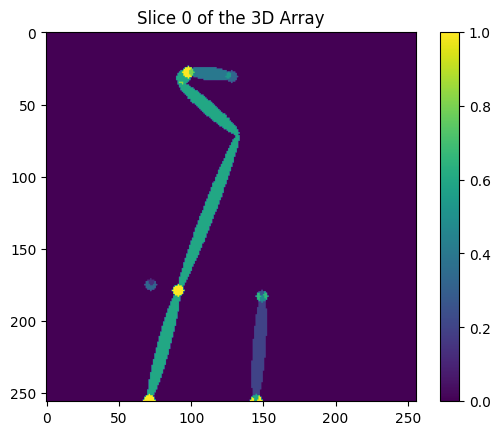

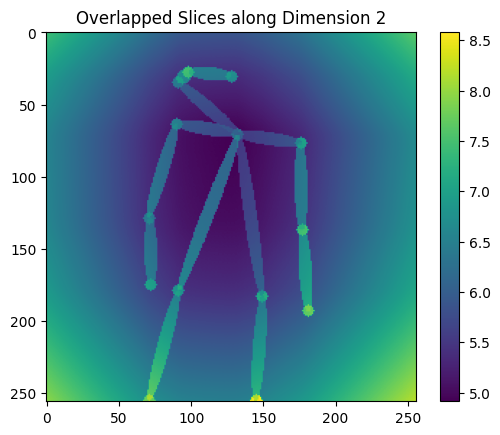

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the NumPy array from the file
# array = np.load('E:/Documents/PythonScripts/PIDM/data/deepfashion_256x256/target_pose/reference_pose_3.npy')

# # Choose the slice you want to visualize (e.g., the first slice along the third dimension)
# slice_index = 0
# slice_to_visualize = array[:, :, slice_index]

# # Create a heatmap of the chosen slice
# plt.imshow(slice_to_visualize, cmap='viridis')
# plt.title(f'Slice {slice_index} of the 3D Array')
# plt.colorbar()
# plt.show()

# # Choose the dimension along which to overlap the slices
# dimension_to_overlap = 2

# # Create an image by stacking all slices along the chosen dimension
# overlapped_image = np.sum(array, axis=dimension_to_overlap)

# # Plot the overlapped image
# plt.imshow(overlapped_image, cmap='viridis')
# plt.title(f'Overlapped Slices along Dimension {dimension_to_overlap}')
# plt.colorbar()
# plt.show()

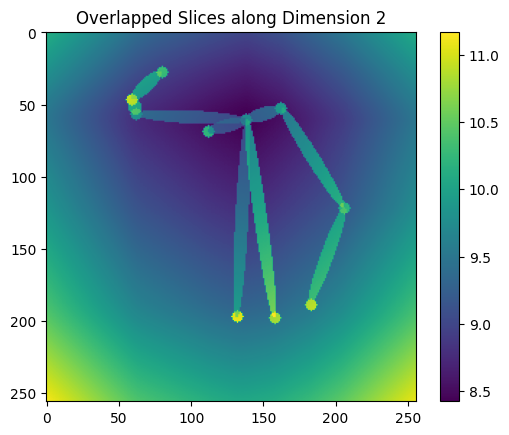